In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima.model import ARIMA
from gmdh import Combi, Mia
from sklearn.metrics import mean_squared_error
from statsmodels.datasets import get_rdataset

In [2]:
# 1. Загрузка данных
data = get_rdataset('sunspots').data

# 2. Преобразование данных (используем правильные имена столбцов)
data['time'] = pd.to_datetime(data['time'])  # преобразуем строки в даты
data.set_index('time', inplace=True)         # делаем даты индексом
ts = data['value']                          # используем столбец value как временной ряд

# 3. Проверка данных
print("Первые 5 записей:")
print(data.head())

print("\nИнформация о данных:")
print(data.info())

Первые 5 записей:
                               value
time                                
1970-01-01 00:00:00.000001749   58.0
1970-01-01 00:00:00.000001749   62.6
1970-01-01 00:00:00.000001749   70.0
1970-01-01 00:00:00.000001749   55.7
1970-01-01 00:00:00.000001749   85.0

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2820 entries, 1970-01-01 00:00:00.000001749 to 1970-01-01 00:00:00.000001983
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   2820 non-null   float64
dtypes: float64(1)
memory usage: 44.1 KB
None


c:\Users\kanae\Desktop\Study\6_sem\ТМО\add_labs\venv\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\kanae\Desktop\Study\6_sem\ТМО\add_labs\venv\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


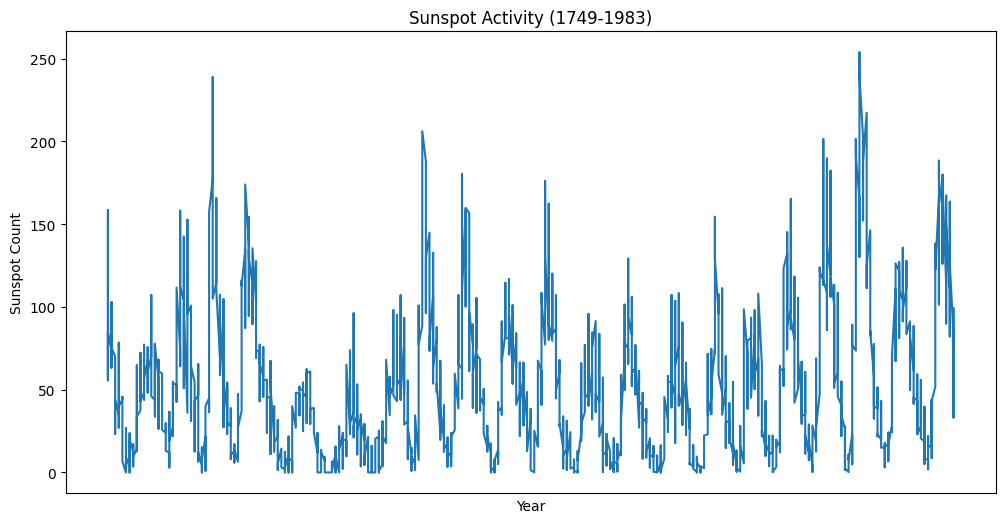

Описательные статистики:
count    2820.000000
mean       51.265957
std        43.448971
min         0.000000
25%        15.700000
50%        42.000000
75%        74.925000
max       253.800000
Name: value, dtype: float64


In [3]:
# 2. Визуализация ряда
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Sunspot Activity (1749-1983)')
plt.xlabel('Year')
plt.ylabel('Sunspot Count')
plt.show()

print("Описательные статистики:")
print(ts.describe())

In [4]:
# 3. Разделение на train/test
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

c:\Users\kanae\Desktop\Study\6_sem\ТМО\add_labs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kanae\Desktop\Study\6_sem\ТМО\add_labs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kanae\Desktop\Study\6_sem\ТМО\add_labs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kanae\Desktop\Study\6_sem\ТМО\add_labs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. 

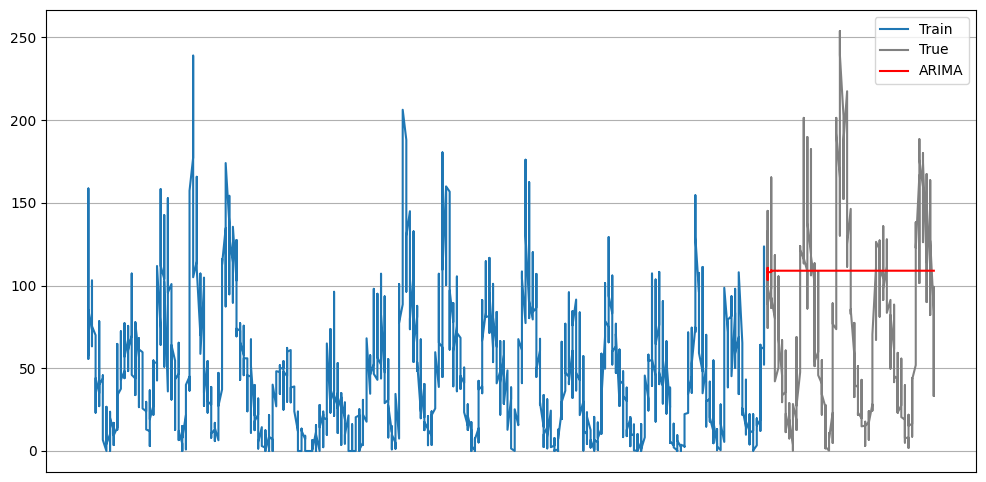

MSE ARIMA: 4003.10


In [5]:
# 4.1 ARIMA прогноз
model_arima = ARIMA(train, order=(11,1,0)) # p=11 (лаги), d=1 (разности), q=0 (MA)
model_fit = model_arima.fit()
arima_forecast = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='True', color='gray')
plt.plot(test.index, arima_forecast, label='ARIMA', color='red')
plt.legend()
plt.grid()
plt.show()

print(f"MSE ARIMA: {mean_squared_error(test, arima_forecast):.2f}")

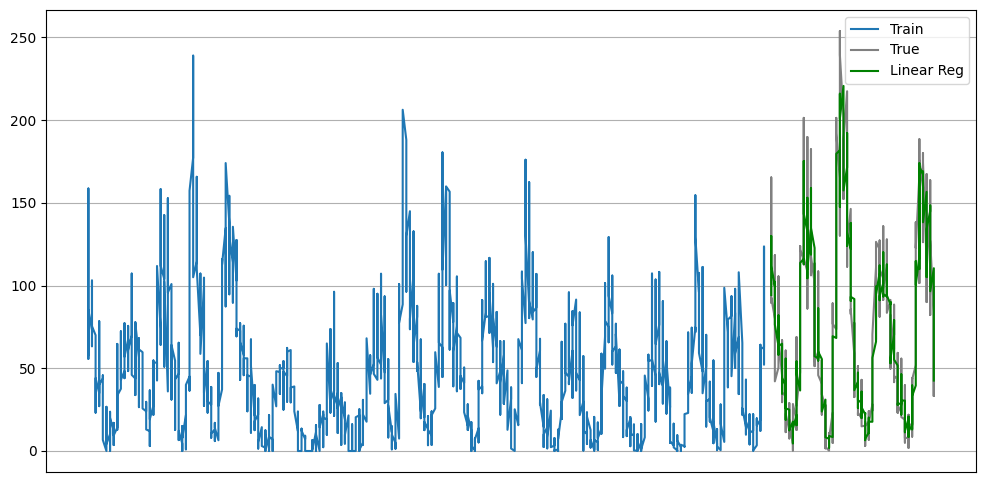

MSE Linear Regression: 341.56


In [6]:
# 4.2 Символьная регрессия (упрощенный вариант)
from sklearn.linear_model import LinearRegression

n_lags = 15

# Создаем признаки на основе лагов
def create_lags(data, n_lags):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_lags(train, n_lags)
X_test, y_test = create_lags(test, n_lags)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
lr_forecast = model_lr.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index[n_lags:], y_test, label='True', color='gray')
plt.plot(test.index[n_lags:], lr_forecast, label='Linear Reg', color='green')
plt.legend()
plt.grid()
plt.show()

print(f"MSE Linear Regression: {mean_squared_error(y_test, lr_forecast):.2f}")

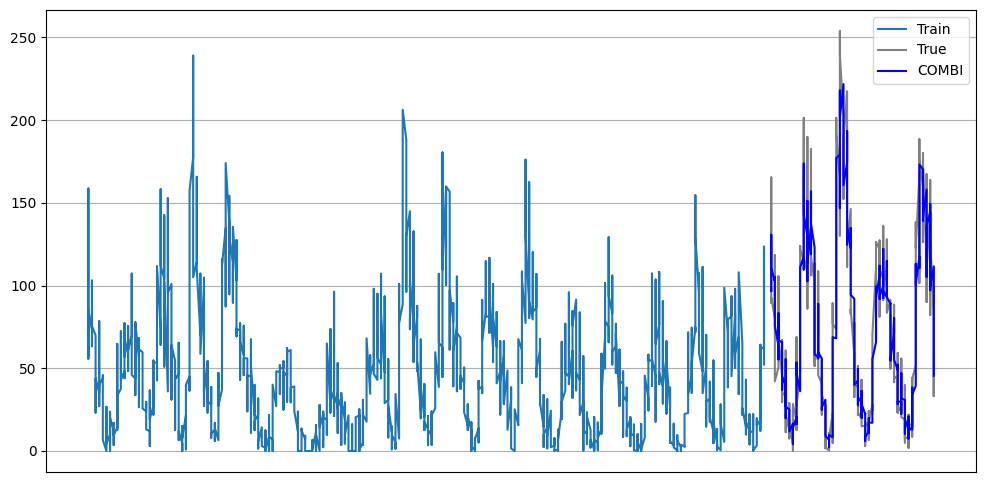

MSE COMBI: 344.10


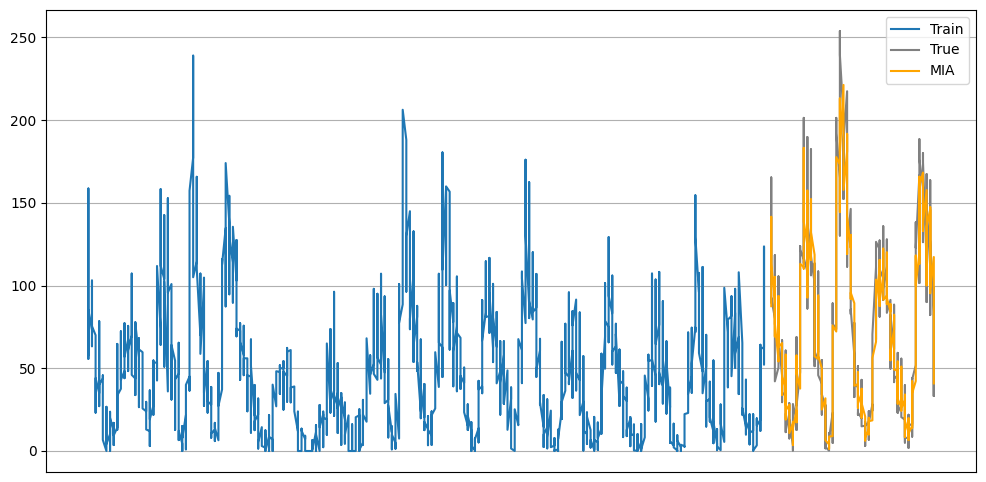

MSE MIA: 359.93


In [7]:
# 4.3 Методы МГУА
# COMBI
model_combi = Combi()
model_combi.fit(X_train, y_train)
combi_forecast = model_combi.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index[n_lags:], y_test, label='True', color='gray')
plt.plot(test.index[n_lags:], combi_forecast, label='COMBI', color='blue')
plt.legend()
plt.grid()
plt.show()

print(f"MSE COMBI: {mean_squared_error(y_test, combi_forecast):.2f}")

# MIA
model_mia = Mia()
model_mia.fit(X_train, y_train)
mia_forecast = model_mia.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index[n_lags:], y_test, label='True', color='gray')
plt.plot(test.index[n_lags:], mia_forecast, label='MIA', color='orange')
plt.legend()
plt.grid()
plt.show()

print(f"MSE MIA: {mean_squared_error(y_test, mia_forecast):.2f}")

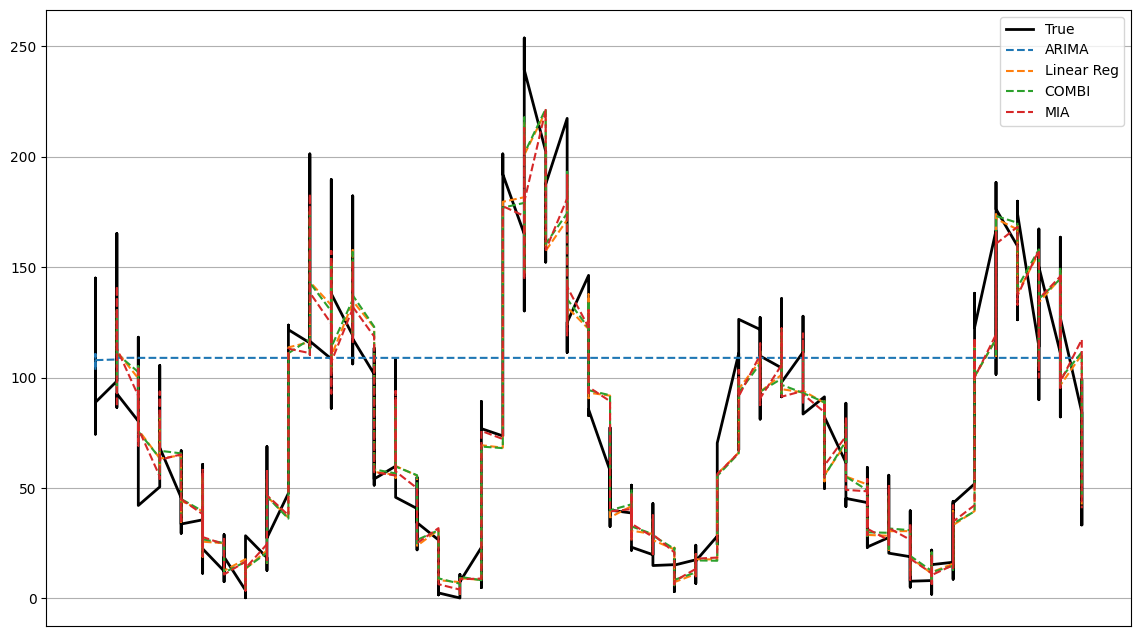

In [8]:
# 5. Сравнение всех методов
plt.figure(figsize=(14, 8))
plt.plot(test.index, test, label='True', color='black', linewidth=2)
plt.plot(test.index, arima_forecast, label=f'ARIMA', linestyle='--')
plt.plot(test.index[n_lags:], lr_forecast, label=f'Linear Reg', linestyle='--')
plt.plot(test.index[n_lags:], combi_forecast, label=f'COMBI', linestyle='--')
plt.plot(test.index[n_lags:], mia_forecast, label=f'MIA', linestyle='--')
plt.legend()
plt.grid()
plt.show()